In [1]:
import os
import time
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score

from convolutional_ar.model import ConvolutionalAR

# Convolutional Autoregressive Model



<img src="https://raw.githubusercontent.com/ryanhammonds/explorations/master/docs/convolution.png" width="500" style="width: 50%; display: block; margin-left: auto; margin-right: auto;"/>

The weights of a convolution kernel are optimized to best predict the center pixel of each window, $\mathbf{X}_i$. The weights of the kernel (Fig. 2b) are linked based on distance from the center, e.g. the first three weights, $\{w_0, w_1, w_2\}$, correspond to indices in the kernel with distances $\{1, \sqrt{2}, 2\}$ from the center pixel. Convolution is the Frobenius inner product between the image and kernel, optimized to best predict the center pixel, $c_i \in \mathbf{X}$.

<img src="https://raw.githubusercontent.com/ryanhammonds/explorations/master/docs/decimation.png" width="600" style="width: 50%; display: block; margin-left: auto; margin-right: auto;"/>


Multiple convolution kernels are learned to account for various spatial scales in image. This is performed by decimating the image by various factors using the same kernel size, resulting in the kernel expanding by the decimation factor. The above image demonstrates this. Decimating the image by a factor of two results in the kernel expanding as shown in c. 


In [2]:
# Image files
base_dir = "datasets/kylberg_rot/"
f = os.listdir(base_dir)
f.sort()
f = [i for i in f if i.endswith('.png')]

# Randomly choose rotation angle
f_rand = []

n_imgs = 4480

i_start = 0
for i in range(n_imgs):
    inds = np.arange(i_start, i_start+12)
    
    np.random.seed(i)
    ind = np.random.choice(inds)
    
    f_rand.append(f[ind])
    i_start += 12

# Classes
classes = [i.split('-')[0].split('.')[0] for i in f]
classes = np.unique(classes)

y = np.arange(len(classes))

classes = {c:int(i) for c, i in zip(classes, y)}
n_classes = len(classes)

# Data and labels
X = torch.zeros(len(f_rand), 576, 576)
y = torch.zeros(len(f_rand))

for i in range(len(f_rand)):
    X[i] = torchvision.io.read_image(f"{base_dir}/{f_rand[i]}")[0]
    y[i] = classes[f_rand[i].split('-')[0].split('.')[0]]

In [3]:
vectors = []

for i in [1, 2, 3, 4, 5]:

    # Decimate
    X_sub = X[:, ::i, ::i]

    # Normalize
    X_sub = (X_sub - X_sub.mean(axis=(1, 2)).reshape(len(X_sub), 1, 1)) / \
        X_sub.std(axis=(1, 2)).reshape(len(X_sub), 1, 1)

    # Fit
    car = ConvolutionalAR(4, verbose=None, n_epochs=20, lr=0.1, loss_fn=torch.nn.L1Loss(), loss_thresh=0.1)
    car.fit(X_sub, progress=lambda i: tqdm(i, total=len(X_sub)))
    
    vectors.append(car.weight_vector_.numpy())

# Save
vectors = np.column_stack(vectors)
np.save("vectors_kylberg.npy", vectors)

  0%|          | 0/4480 [00:00<?, ?it/s]

  0%|          | 0/4480 [00:00<?, ?it/s]

  0%|          | 0/4480 [00:00<?, ?it/s]

  0%|          | 0/4480 [00:00<?, ?it/s]

  0%|          | 0/4480 [00:00<?, ?it/s]

In [4]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(vectors, y.numpy(), train_size=0.9)

# Normalize
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

# Fit SVM
svc = SVC(C=1e3, probability=True)
svc.fit(X_train, y_train)

# Accuracy
print('Train Accuracy: ', (svc.predict(X_train) == y_train).sum() / len(y_train))
print('Test  Accuracy: ', (svc.predict(X_test) == y_test).sum() / len(y_test))

Train Accuracy:  0.9992559523809523
Test  Accuracy:  0.9955357142857143


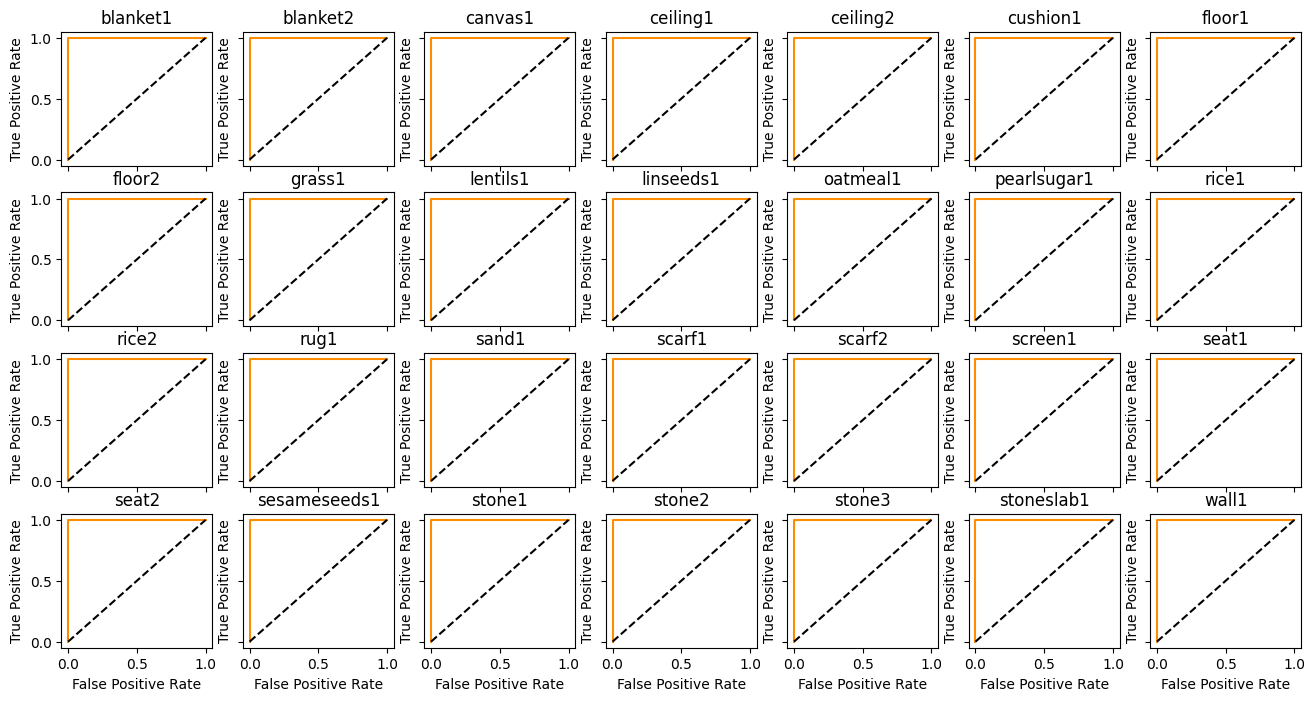

In [5]:
# Plot examples
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)

y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

y_score = svc.predict_proba(X_test)


fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(16, 8), sharex=True, sharey=True)
axes = axes.flatten()

for c in classes.keys():
    i = classes[c]

    RocCurveDisplay.from_predictions(
        y_onehot_test[:, i],
        y_score[:, i],
        name=f"{c} vs the rest",
        color="darkorange",
        plot_chance_level=True,
        ax=axes[i]
    )
    axes[i].set_ylabel("True Positive Rate")
    if i > 20:
        axes[i].set_xlabel("False Positive Rate") 
    else:
        axes[i].set_xlabel("")
    axes[i].get_legend().remove()
    axes[i].set_title(f"{c}")